<a href="https://colab.research.google.com/github/Mikhail-Klochkov/ml_intro/blob/master/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22Task1_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Релизуйте свой классификатор KNN

### Импорты

In [165]:
import numpy as np
import pandas as pd
import random
from sklearn.datasets import make_moons
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
%matplotlib inline

### Реализуйте класс MyKNeighborsClassifier (6 баллов)

1. (3 балла) Реализован класс с параметрами по умолчанию
2. (1 балл) Реализовано манхетенское расстояние `(metric='manhattan')`
3. (2 балла) Реализованы веса, зависящие от растояния `(weights='distance')`



$$X_{1} - > [x_{(1)}^{1 T}, ..., x_{(1)}^{n_{1} T}]$$
$$X_{2} - > [x_{(2)}^{1 T}, ..., x_{(2)}^{n_{2} T}]$$

$$d(x_{(1)}^{i}, x_{(2)}^{j}) = d_{i, j} $$

In [166]:
def compute_pair_distance(X1, X2, metric = 'euclidean'):
  """
  input:
  X1 - np.ndarray (n1, m)
  X2 - np.ndarray (n2, m)
  output:
  d_{i, j} D - np.ndarray (n1, n2)
  """
  assert(X1.shape[1] == X2.shape[1])
  if(metric == 'euclidean'):
    # можно более оптимально написать
    return np.sqrt(((X1 - X2[:, None]) ** 2).sum(axis = 2).T)
  elif(metric == 'manhattan'):
    return (np.fabs(X1 - X2[:, None])).sum(axis = 2).T

def compute_pair_distance_fast(X1 : np.ndarray, \
                               X2: np.ndarray) -> np.ndarray:
  """
  input:
  X1 - np.ndarray (n1, m)
  X2 - np.ndarray (n2, m)
  output:
  d_{i, j} D - np.ndarray (n1, n2)
  """
  assert(X1.shape[1] == X2.shape[1])
  return np.sqrt(np.reshape(np.sum(X1**2, axis=1), [X1.shape[0],1]) + np.sum(X2**2, axis=1) \
            - 2 * np.matmul(X1, X2.T))


def compute_pair_distance_for_ver(X1, X2, metric = 'euclidean'):
  assert(X1.shape[1] == X2.shape[1])
  D = np.zeros((X1.shape[0], X2.shape[0]))
  if(metric == 'euclidean'):
    d = lambda x1, x2: np.sqrt(((x1 - x2) ** 2).sum())
  elif(metric == 'manhattan'):
    d = lambda x1, x2: np.fabs(x1 - x2).sum()
  for i, x1 in enumerate(X1):
    for j, x2 in enumerate(X2):
      D[i, j] = d(x1, x2)
  return D


In [167]:
from sklearn.metrics.pairwise import euclidean_distances
%timeit euclidean_distances(X1, X2) 

The slowest run took 7.66 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 109 µs per loop


In [168]:
def LOO_my(cls_classifier, X_train, y_train, k_range, **kwargs):
  losses_k = []
  for i, k in enumerate(k_range):
    loss_current = 0
    for idx, (x, y) in enumerate(zip(X_train, y_train)):
      
      model = cls_classifier()
      for key, value in kwargs.items():
        if('n_neigh' in key):
          model.__dict__[key] = value + i
        else:
          model.__dict__[key] = value
        
    
      X_without_x = np.vstack((X_train[:idx], X_train[idx+1:]))
      y_without_y = np.hstack((y_train[:idx], y_train[idx+1:]))
      model.fit(X_without_x, y_without_y)
      loss_current += (y != model.predict(x.reshape((1, -1))).flatten()[0]).astype(int)
    #print('for k: {} loss is : {}'.format(k, loss_current))
    losses_k.append(loss_current)
  return k_range[np.argmin(losses_k)], losses_k


Все для метрки euclidean:
accuracy knn_my( weights = 'distance', metric = 'euclidean'): 89.50
accuracy knn_sklearn( weights = 'distance', metric = 'euclidean'): 89.50
accuracy knn_my(weights = 'uniform', metric = 'euclidean'): 90.00
accuracy knn_sklearn(weights = 'uniform', metric = 'euclidean'): 90.00


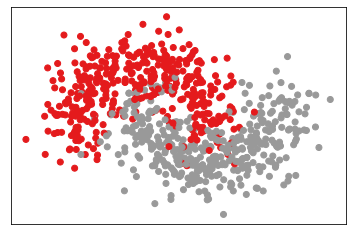

In [266]:
# Мой класс
class MyKnn_ver2:
  def __init__(self, n_neighbours = 5, weights = 'uniform', metric = 'euclidean'):
    self.n_neighbours = n_neighbours
    self.weights = weights
    self.metric = metric

    self.X = None
    self.y = None

  def fit(self, X, y):
    self.X = X
    self.y = y

  def predict(self, X):
    if(X.shape.__len__() == 1):
      assert(X.shape[0] == self.X.shape[1])
      X = X[np.newaxis, :]
    D = compute_pair_distance(self.X, X, metric = self.metric)
    indeces = np.argsort(D, axis = 0)
    D_sort = np.sort(D, axis = 0)
    y_unique = np.unique(self.y)
    # not change 
    if(self.weights == 'uniform'):
      loss = np.empty((y_unique.shape[0], X.shape[0]))
      for idx, y in enumerate(y_unique):
        loss[idx, :] = (self.y[indeces[: self.n_neighbours]] == y).sum(axis = 0)
      return y_unique[loss.argmax(axis = 0)]
    else:
      eps = 1e-3 # for special case (1/x+eps) = (1/0 + eps)
      D_sort = D_sort[: self.n_neighbours] # Остальные не нужны
      D_sort_inv = 1/(D_sort + eps)
      D_sort_inv_norm = D_sort_inv/(D_sort_inv.sum(axis = 0)) # should be into [0, 1] interval
      #print(D_sort_inv_norm, D_sort)
      loss = np.empty((y_unique.shape[0], X.shape[0]))
      for idx, y in enumerate(y_unique):
        mask = (self.y[indeces[: self.n_neighbours]] == y)
        for ind in range(X.shape[0]):
          loss[idx, ind] =  D_sort_inv_norm[mask[:, ind]][:, ind].sum()
          #print('value: {}'.format(D_sort_inv_norm[mask[:, ind]][:, ind]), mask[:, ind])
      return y_unique[loss.argmax(axis = 0)]

def accuracy_score(y_test, y_pred):
  assert(y_test.shape == y_pred.shape)
  return (y_test == y_pred).sum()/(y_pred.shape[0]) * 100

X_new, y_new = make_moons(n_samples = 1000, noise = 0.3, random_state=42) 
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size = 0.2, random_state=42)

plt.scatter(X_train_new[:, 0], X_train_new[:, 1], c = y_train_new, cmap = plt.cm.Set1)
plt.xticks([])  
plt.yticks([])

print('Все для метрки euclidean:')
knn_ver_2 = MyKnn_ver2(n_neighbours = 5, weights = 'distance', metric = 'euclidean')
knn_ver_2.fit(X_train_new, y_train_new)
print("accuracy knn_my( weights = 'distance', metric = 'euclidean'): {:.2f}".format(accuracy_score(y_test_new, knn_ver_2.predict(X_test_new))))

knn_sk_dist = KNeighborsClassifier(n_neighbors = 5, weights = 'distance', metric = 'euclidean')
knn_sk_dist.fit(X_train_new, y_train_new)
print("accuracy knn_sklearn( weights = 'distance', metric = 'euclidean'): {:.2f}".format(accuracy_score(y_test_new, knn_sk_dist.predict(X_test_new))))

knn_sk_un = KNeighborsClassifier(n_neighbors = 5, weights = 'uniform', metric = 'euclidean')
knn_sk_un.fit(X_train_new, y_train_new)
print("accuracy knn_my(weights = 'uniform', metric = 'euclidean'): {:.2f}".format(accuracy_score(y_test_new, knn_sk_un.predict(X_test_new))))

knn_my_un = MyKnn_ver2(n_neighbours = 5, weights = 'uniform', metric = 'euclidean')
knn_my_un.fit(X_train_new, y_train_new)
print("accuracy knn_sklearn(weights = 'uniform', metric = 'euclidean'): {:.2f}".format(accuracy_score(y_test_new, knn_my_un.predict(X_test_new))))


In [267]:
print('Все для метрки manhattan:')
knn_ver_2 = MyKnn_ver2(n_neighbours = 5, weights = 'distance', metric = 'manhattan')
knn_ver_2.fit(X_train_new, y_train_new)
print("accuracy knn_my( weights = 'distance', metric = 'manhattan'): {:.2f}".format(accuracy_score(y_test_new, knn_ver_2.predict(X_test_new))))

knn_sk_dist = KNeighborsClassifier(n_neighbors = 5, weights = 'distance', metric = 'manhattan')
knn_sk_dist.fit(X_train_new, y_train_new)
print("accuracy knn_sklearn( weights = 'distance', metric = 'manhattan'): {:.2f}".format(accuracy_score(y_test_new, knn_sk_dist.predict(X_test_new))))

knn_sk_un = KNeighborsClassifier(n_neighbors = 5, weights = 'uniform', metric = 'manhattan')
knn_sk_un.fit(X_train_new, y_train_new)
print("accuracy knn_my(weights = 'uniform', metric = 'manhattan'): {:.2f}".format(accuracy_score(y_test_new, knn_sk_un.predict(X_test_new))))

knn_my_un = MyKnn_ver2(n_neighbours = 5, weights = 'uniform', metric = 'manhattan')
knn_my_un.fit(X_train_new, y_train_new)
print("accuracy knn_sklearn(weights = 'uniform', metric = 'manhattan'): {:.2f}".format(accuracy_score(y_test_new, knn_my_un.predict(X_test_new))))


Все для метрки manhattan:
accuracy knn_my( weights = 'distance', metric = 'manhattan'): 91.00
accuracy knn_sklearn( weights = 'distance', metric = 'manhattan'): 91.00
accuracy knn_my(weights = 'uniform', metric = 'manhattan'): 91.00
accuracy knn_sklearn(weights = 'uniform', metric = 'manhattan'): 91.00


Можно наблюдать, что для приведенных выше параметрах и при числе соседей k = 5 custom алгоритм и knn_sklearn показывают одну и ту же точность. Далее стоит для разных k посмотреть те же оценки.

In [268]:
# подберём для каждой модели свой оптимальный k и отталкиваясь от этого попробуем заключить, какой алгоритм работает лучше, с учётом
# distance параметра или uniform, так как пока мы не подобрали для каждой модели оптимальный k, мы не можем говорить о его приемуществе
# приминительно к данному dataset
# подбор параметров k осуществляется с помщью Leave_one_out (см. Лекции Воронцова)
weights_l = ['uniform', 'distance']
metrics_l = ['euclidean', 'manhattan']
kbest_dict = {}
k_losses_dict = {}
k_range = np.arange(3, 27, 2) # Для бинарной классификации логично брать нечетное число соседей [3-25]
for idx, weights in enumerate(weights_l):
  for jdx, metric in enumerate(metrics_l):
    k_best, k_losses = LOO_my(MyKnn_ver2, X_train_new, y_train_new, k_range = k_range, \
                              metric = metric, weights = weights, n_neighbours = 3) # Начальный утановили
    kbest_dict[weights + '_' + metric] = k_best
    k_losses_dict[weights + '_' + metric] = k_losses



In [269]:
# Тоже самое для sklearn 
metricssk_l = [1, 2]
kbest_dict_sk = {}
k_losses_dict_sk = {}

for idx, weights in enumerate(weights_l):
  for jdx, p in enumerate(metricssk_l):
    k_best, k_losses = LOO_my(KNeighborsClassifier, X_train_new, y_train_new, k_range = k_range, \
                              p = p, weights = weights, n_neighbors = 3) # Начальный утановили
    kbest_dict_sk[weights + '_minkovski' + str(p)] = k_best
    k_losses_dict_sk[weights + '_minkovski' + str(p)] = k_losses

In [270]:
kbest_dict_sk, k_losses_dict_sk

({'distance_minkovski1': 25,
  'distance_minkovski2': 25,
  'uniform_minkovski1': 13,
  'uniform_minkovski2': 11},
 {'distance_minkovski1': [86, 86, 79, 80, 77, 74, 72, 72, 70, 70, 69, 67],
  'distance_minkovski2': [85, 80, 78, 76, 73, 73, 76, 72, 72, 69, 70, 68],
  'uniform_minkovski1': [76, 75, 70, 66, 69, 62, 62, 63, 63, 67, 65, 68],
  'uniform_minkovski2': [75, 73, 69, 67, 63, 69, 66, 66, 64, 66, 65, 68]})

In [271]:
# поиск наилучших алгоритмов по стратегии Leave-one-out для реализации sklearn
for key, value in kbest_dict_sk.items():
  weights, metric = key.split('_')
  knn_current = KNeighborsClassifier(n_neighbors = value, weights = weights, p = int(metric[-1]))
  knn_current.fit(X_train_new, y_train_new)
  params = 'weights = ' + weights + ', metric = ' + metric
  accuracy = (y_test_new == knn_current.predict(X_test_new)).sum()/y_test_new.size
  print('accuracy knn_sk({}) : {}'.format(params, accuracy))

accuracy knn_sk(weights = uniform, metric = minkovski1) : 0.92
accuracy knn_sk(weights = uniform, metric = minkovski2) : 0.92
accuracy knn_sk(weights = distance, metric = minkovski1) : 0.91
accuracy knn_sk(weights = distance, metric = minkovski2) : 0.91


In [272]:
# Выведем для настоенных параметров k для моей реализации
for key, value in kbest_dict.items():
  weights, metric = key.split('_')
  knn_current = MyKnn_ver2(n_neighbours = value, weights = weights, metric = metric)
  knn_current.fit(X_train_new, y_train_new)
  params = 'weights = ' + weights + ', metric = ' + metric
  accuracy = (y_test_new == knn_current.predict(X_test_new)).sum()/y_test_new.size
  print('accuracy knn_my({}) : {}'.format(params, accuracy))


accuracy knn_my(weights = uniform, metric = euclidean) : 0.92
accuracy knn_my(weights = uniform, metric = manhattan) : 0.92
accuracy knn_my(weights = distance, metric = euclidean) : 0.91
accuracy knn_my(weights = distance, metric = manhattan) : 0.915


Можно видеть, что после подбора количества ближайших соседей стратегией Leave - one - out, точность алгоритмов custom реализации и sklearn очень схожи. Но как будет показано позже, для данного датасета, как оказывается это не лучшая стратегия подбора гиперпараметра k. Обычной cross-validation KFold с перемешиванием получиться подобрать параметр лучшим образом! При этом вычислительные затраты достаточно большие. 

In [273]:
# настройка параметров на основе pipeline (scaling)
from sklearn.model_selection import GridSearchCV
from sklearn.base import (
    BaseEstimator, TransformerMixin,
    ClassifierMixin, RegressorMixin
    )

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import KFold

# Тот же самый класс, только по удобнее, чтобы его скормить GridSearch
class MyKnnClassifier(BaseEstimator, ClassifierMixin):

  def __init__(self, n_neighbours : int = 5, 
               weights: str = "uniform", 
               metric: str = "euclidean",
               ) -> None:
    if metric not in ["manhattan", "euclidean"]:
      raise ValueError("This type of metric is not supported: {}".format(metric))
    if weights not in ["uniform", "distance"]:
      raise ValueError("This type of weights is not supported: {}".format(weights))
    
    self.n_neighbours = n_neighbours
    self.weights = weights
    self.metric = metric

    self.X = None
    self.y = None
  
  def fit(self, X: np.ndarray, y: np.ndarray) -> None:
    self.X = X
    self.y = y
    return self

  @staticmethod
  def compute_pair_distance_fast(X1 : np.ndarray, \
                               X2: np.ndarray, metric: str = 'euclidean') -> np.ndarray:
    """
    input:
    X1 - np.ndarray (n1, m)
    X2 - np.ndarray (n2, m)
    output:
    d_{i, j} D - np.ndarray (n1, n2)
    """
    assert(X1.shape[1] == X2.shape[1])
    if metric == 'euclidean':
      return np.sqrt(np.reshape(np.sum(X1**2, axis=1), [X1.shape[0],1]) + np.sum(X2**2, axis=1) \
                - 2 * np.matmul(X1, X2.T))
    else:
      return (np.fabs(X1 - X2[:, None])).sum(axis = 2).T
  

  def predict(self, X: np.ndarray) -> np.ndarray:
    if(X.shape.__len__() == 1):
      assert(X.shape[0] == self.X.shape[1])
      X = X[np.newaxis, :]
    D = self.compute_pair_distance_fast(self.X, X, metric = self.metric)
    indeces = np.argsort(D, axis = 0)
    D_sort = np.sort(D, axis = 0)
    y_unique = np.unique(self.y)
    if(self.weights == 'uniform'):
      loss = np.empty((y_unique.shape[0], X.shape[0]))
      for idx, y in enumerate(y_unique):
        loss[idx, :] = (self.y[indeces[: self.n_neighbours]] == y).sum(axis = 0)
      return y_unique[loss.argmax(axis = 0)]
    else:
      eps = 1e-3
      D_sort = D_sort[: self.n_neighbours] 
      D_sort_inv = 1/(D_sort + eps)
      D_sort_inv_norm = D_sort_inv/(D_sort_inv.sum(axis = 0)) 
      loss = np.empty((y_unique.shape[0], X.shape[0]))
      for idx, y in enumerate(y_unique):
        mask = (self.y[indeces[: self.n_neighbours]] == y)
        for ind in range(X.shape[0]):
          loss[idx, ind] =  D_sort_inv_norm[mask[:, ind]][:, ind].sum()
          
      return y_unique[loss.argmax(axis = 0)]


In [274]:
param_grid_sk = [{
    'kneighborsclassifier__n_neighbors' : np.arange(3, 30, 2),
    'kneighborsclassifier__weights' : ['uniform', 'distance'],
    #'myknnclassifier__metric' : ['euclidean', 'manhattan']
}]

In [275]:

param_grid = [{
    'myknnclassifier__n_neighbours' : np.arange(3, 30, 2),
    'myknnclassifier__weights' : ['uniform', 'distance'],
    #'myknnclassifier__metric' : ['euclidean', 'manhattan']
}]
pipe_sk = make_pipeline(
    KNeighborsClassifier(), 
)
pipe = make_pipeline(
    MyKnnClassifier(),
)
cv = KFold(n_splits = 5, shuffle = True, random_state = 42)
cv_sk = KFold(n_splits = 5, shuffle = True, random_state = 45)
gscv = GridSearchCV(pipe, param_grid = param_grid, scoring = 'accuracy', n_jobs = -1, cv = cv)
gscv_sk = GridSearchCV(pipe_sk, param_grid = param_grid_sk, scoring = 'accuracy', n_jobs = -1, cv = cv_sk)

gscv.fit(X_new, y_new)
gscv_sk.fit(X_new, y_new)


GridSearchCV(cv=KFold(n_splits=5, random_state=45, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('kneighborsclassifier',
                                        KNeighborsClassifier(algorithm='auto',
                                                             leaf_size=30,
                                                             metric='minkowski',
                                                             metric_params=None,
                                                             n_jobs=None,
                                                             n_neighbors=5, p=2,
                                                             weights='uniform'))],
                                verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'kneighborsclassifier__n_neighbors': array([ 3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]),
                       

In [276]:
# Для реализованного мной классификатора 
# Для sklearn по той же сетке искать лучшие параметры
print('my best parameters after GCV: ', gscv.best_params_, gscv.best_score_)
print('sklearn best parameters after GCV: ', gscv_sk.best_params_, gscv_sk.best_score_)


my best parameters after GCV:  {'myknnclassifier__n_neighbours': 11, 'myknnclassifier__weights': 'distance'} 0.922
sklearn best parameters after GCV:  {'kneighborsclassifier__n_neighbors': 19, 'kneighborsclassifier__weights': 'distance'} 0.9269999999999999


# что-то про параметры подобранные по GridSearch, что они довольно неплохие

для диапазона k:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] число элементов выборки:  1000


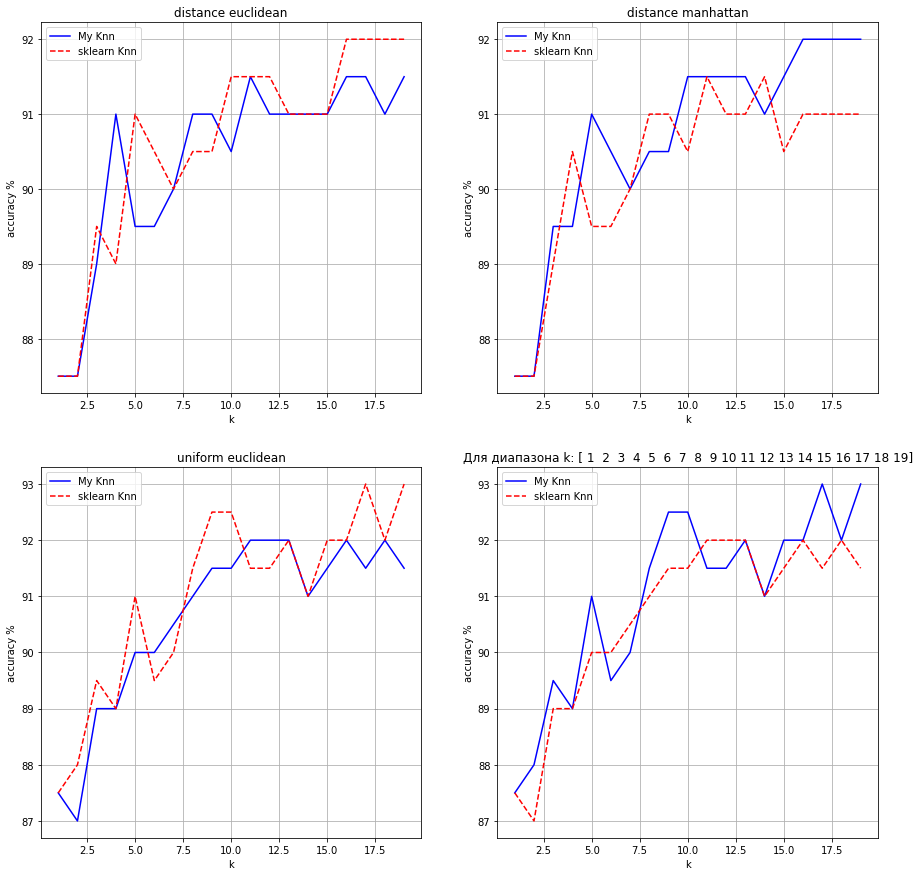

In [291]:
# Графики для k = 1-10 
weights = ['distance', 'uniform']
metrics = ['euclidean', 'manhattan'] # for my realization
ps = [1, 2] # for sklearn 

nrows = 2
ncols = 2
k_range_tot = np.arange(1, 20, 1)

print('для диапазона k: ', str(k_range_tot), 'число элементов выборки: ', 1000)
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (15, 15))
for row, weight in enumerate(weights):
  for col, (metric, p) in enumerate(zip(metrics, ps)):
    # По сути для каждого графика отдельно
    acc_my = []
    acc_sk = []
    for k in k_range_tot:
    
      knn_my = MyKnnClassifier(n_neighbours = k, metric = metric, weights = weight)
      knn_sk = KNeighborsClassifier(n_neighbors = k, weights = weight, p = p, metric = 'minkowski')
      knn_my.fit(X_train_new, y_train_new)
      knn_sk.fit(X_train_new, y_train_new)
      acc_my.append(accuracy_score(y_test_new, knn_my.predict(X_test_new)))
      acc_sk.append(accuracy_score(y_test_new, knn_sk.predict(X_test_new)))
    axes[row][col].plot(k_range_tot, acc_my, c = 'b', label = 'My Knn')
    axes[row][col].set_xlabel('k')
    axes[row][col].set_ylabel('accuracy %')
    axes[row][col].grid()
    axes[row][col].set_title(weight + ' ' + metric)
    axes[row][col].plot(k_range_tot, acc_sk, c = 'r', linestyle = '--', label = 'sklearn Knn')
    axes[row][col].legend()

plt.title('Для диапазона k: ' + str(k_range_tot));
      

(3, 2)

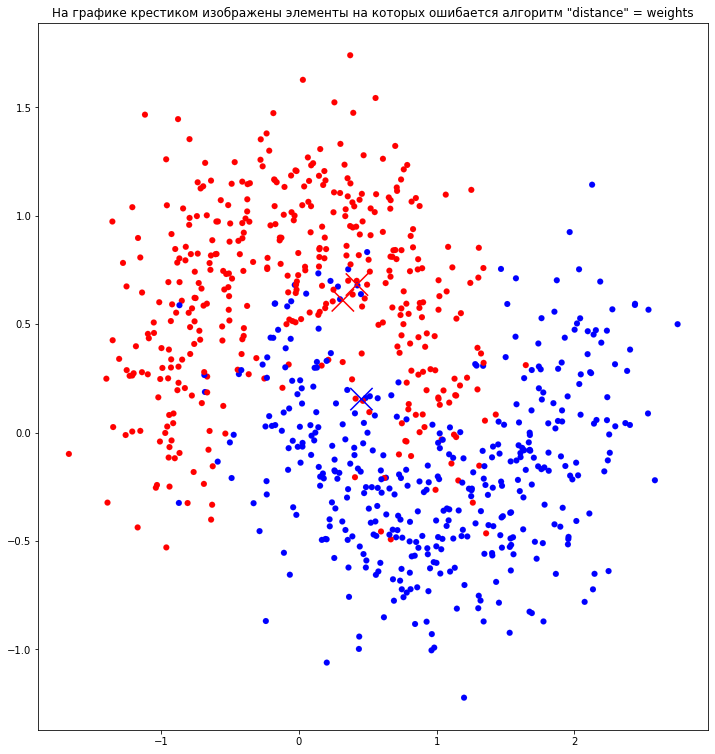

In [285]:
# посмотрим на каких данных ошибается версия с параметрами weights = distance, при этом на uniform даётся правильный ответ
knn_uniform = MyKnnClassifier(11)
knn_dist = MyKnnClassifier(11, weights = 'distance')
knn_uniform.fit(X_train_new, y_train_new)
knn_dist.fit(X_train_new, y_train_new)

pred_d = knn_dist.predict(X_test_new)
pred_un = knn_uniform.predict(X_test_new)

indeces = np.arange(y_test_new.size)
correct_idx_un = indeces[(y_test_new == pred_un)]
error_idx_un = indeces[(y_test_new != pred_un)]

error_idx_d = indeces[(y_test_new != pred_d)]
correct_idx_d = indeces[(y_test_new == pred_d)]
correct_idx_un, error_idx_d
# Индексы примеров из теста которые правильно классифицирует uniform, но неправильно отвечает distance
idxs = np.intersect1d(correct_idx_un, error_idx_d) # На чём ошибается distance и не ошибается uniform
idxs_another = np.intersect1d(error_idx_un, correct_idx_d) # На чём ошибается distance и не ошибается uniform

colors_train = list(map(lambda l: 'red' if l == 0 else 'blue', y_train_new))
color_errors = list(map(lambda l: 'red' if l == 0 else 'blue', y_test_new[idxs]))

fig, ax = plt.subplots(figsize = (12, 13))
plt.scatter(X_train_new[:, 0], X_train_new[:, 1], c = colors_train, linewidths = 0.1)
plt.scatter(X_test_new[idxs, 0], X_test_new[idxs, 1], c = color_errors, 
                                  marker = 'x', cmap = plt.cm.Set1, s = 500)
plt.title('На графике крестиком изображены элементы на которых ошибается алгоритм "distance" = weights')

len(idxs), len(idxs_another)

Крестиком нарисованы метки из теста, на которых ошибается алгоритм с distance весами и на которых правильно отвечает uniform алгоритм. В данном случае (с данной выборкой), когда разные объекты взаимно проникают в друг дурга, в виду большого шума, а также с фиксированным количеством элементов 500. Алгоритм distance ошибается чуть сильнее чем uniform. НО это не означает, что данное усовершенстование алгоритма не нужно и бессмысленно, выше мы оговаривали в каких случаях алгоритм с весами будет работать лучше и в каком смысле. Просто данный случай (данное распределение размеченных признаков) не очень хорошо попадает под нашу гипотезу о том, что соотносить объект к определенному классу стоит некоторым взвешенным образом, где веса убывают при увеличении расстояния между объектами обучающей выборки и валидационной. 

Можно заметить, что при размере выборки в 1000 объектов. Точность, что одного алгоритма, что другого алгоритма практически совпадает. 

Количество объектов на чём ошибается distance и не ошибается uniform := 3 при k = 11 (лучший для distance случая в смысле KFold(5))
Количество объектов на чём ошибается uniform и не ошибается distance := 2 при k = 11 (лучший для distance случая в смысле KFold(5))

### Проверьте решение на датасете и сравните с kNeighborsClassifier из sklearn (4 балла)
1. (1 балл) Выведите accuracy_score для вашего решения и для решения из sklearn, посчитайте в 4 вариациях (Должно получиться 8 чисел)
  1. Параметры по умолчанию
  2. `weights='distance'`
  3. `metric='manhattan'`
  4. `weights='distance'`, `metric='manhattan'`
2. (2 балла) Переберите параметр k от 1 до 10 для каждой модели из пункта выше (получится 4 графика по две линии на каждом)
  1. Переберите параметр, каждый раз обучайте модель
  2. Выведите график зависимости `accuracy` от `k`
  3. На этом же графике выведите пунктирной линией такую же зависимость для модели из sklearn
3. (3 балла) Напишите вывод, сравнение всего, что получилось – получилось ли у вас достичь таких же результатов, как в sklearn, как на результат влияют параметры, какая модель и с какими параметрами оказалась лучшей.



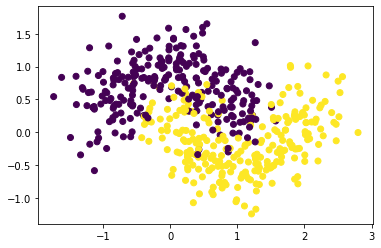

In [72]:
X, y = make_moons(n_samples=500, noise=0.3, random_state=42)
plt.scatter(X[:, 0], X[:, 1], c=y)

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

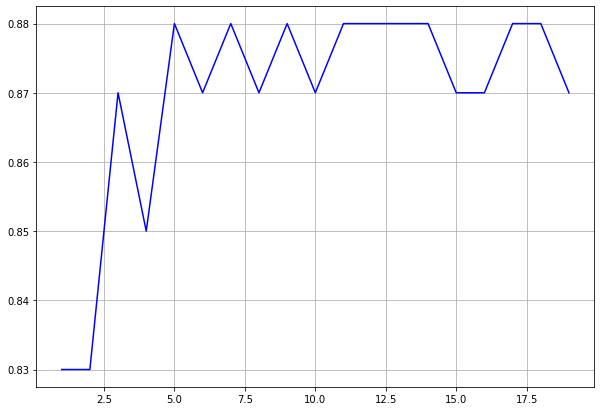

In [75]:
acc_list_my = []
k_range_for_ans = range(1, 20, 1)
for k in k_range_for_ans:
  model_k = MyKnn_ver2(n_neighbours = k, weights = 'distance', metric= 'manhattan')
  model_k.fit(X_train, y_train)
  y_pred = model_k.predict(X_test)
  acc_list_my.append((y_test == y_pred).sum()/y_test.shape[0])

plot_loss_by_k(k_range_for_ans, acc_list_my)


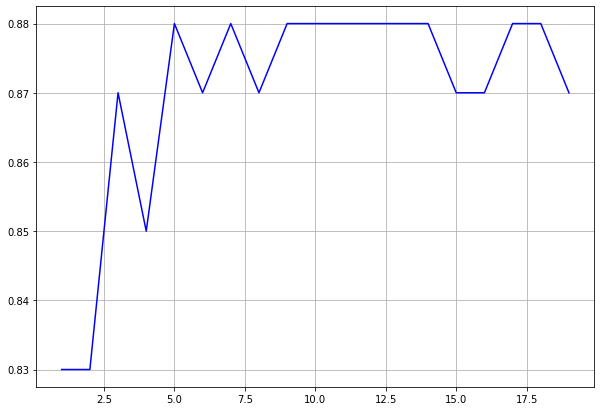

In [76]:
acc_list_sk = []
k_range_for_ans = range(1, 20, 1)
for k in k_range_for_ans:
  model_k = KNeighborsClassifier(n_neighbors = k, weights = 'distance', metric = 'manhattan')
  model_k.fit(X_train, y_train)
  y_pred = model_k.predict(X_test)
  acc_list_sk.append((y_test == y_pred).sum()/y_test.shape[0])

plot_loss_by_k(k_range_for_ans, acc_list_sk)

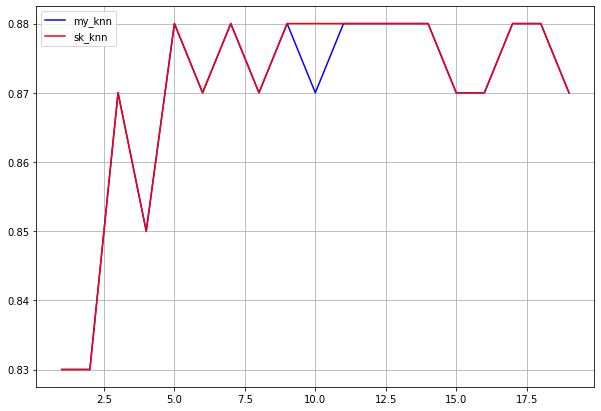

In [77]:
# merge graps #
fig = plt.gcf()
fig.set_size_inches(10, 7)
plt.plot(k_range_for_ans, acc_list_my, c = 'b', label = 'my_knn')
plt.plot(k_range_for_ans, acc_list_sk, c = 'r', label = 'sk_knn')
plt.grid()
plt.legend()

In [79]:
knn_test_time_my = MyKnn_ver2(n_neighbours = 10, weights = 'distance', metric = 'euclidean')
knn_test_time_my.fit(X_train, y_train)
%timeit knn_test_time_my.predict(X_test)

100 loops, best of 3: 7.15 ms per loop


In [80]:
knn_test_time_sk = KNeighborsClassifier(n_neighbors = 10, weights = 'distance', metric = 'euclidean')
knn_test_time_sk.fit(X_train, y_train)
%timeit knn_test_time_sk.predict(X_test)

1000 loops, best of 3: 908 µs per loop
